In [13]:
import numpy as np
import pandas as pd
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

### Device 세팅

In [14]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

torch.manual_seed(1)
if device == 'mps':
    torch.mps.manual_seed(1)

print(device)


mps


### 모델 및 학습 정의

In [15]:
DROP_OUT_R = 0.5
LEARNING_RATE = 0.001

EPOCHS = 500
BATCH_SIZE = 50
#VALIDATION_RATE = 0.1

CHECK_INTERVAL = 10
# EARLY_STOP = 30

In [16]:
class CNN_use_V(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=30, kernel_size=(1,2)),
            nn.Dropout(DROP_OUT_R),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=30, out_channels=15, kernel_size=(1,2)),
            nn.Dropout(DROP_OUT_R),
            nn.LeakyReLU()
        )

        self.linear_layer = nn.Sequential(
            nn.Linear(15*1*8,1),
            nn.LeakyReLU()
        )

    def forward(self, input_X):
        X1 = self.conv_layer(input_X)
        X1_flatten = X1.view(X1.shape[0], -1)
        y = self.linear_layer(X1_flatten)
        return y

CNN_30K_15K = CNN_use_V().to(device)

In [17]:
# 파라미터 개수 확인
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(CNN_30K_15K)) #사용

1126


In [18]:
loss_func = nn.MSELoss()
optimizer = optim.Adam(CNN_30K_15K.parameters(), lr=LEARNING_RATE)

### 학습 과정 정의

In [19]:
train_losses = []

In [20]:
def train_model(train_loader, epochs, check_interval):
    
    for e in range(epochs):
        train_loss = 0
        
        CNN_30K_15K.train()
        for x_batch, y_batch in train_loader:

            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            
            pred_y = CNN_30K_15K(x_batch)
            loss = loss_func(pred_y, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()    
            
            train_loss += loss.item()

        train_loss = train_loss/len(train_loader)
        train_losses.append(train_loss)
        
        if (e % check_interval) == 0:
            print("epoch : ", e, "train loss: ",train_losses[-1])

### Custom Dataset Type 정의

In [21]:
class BAT_DATASET(Dataset):
    def __init__(self, X, y):
        super().__init__()
        X = deepcopy(X)
        y = deepcopy(y)
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    

    def __getitem__(self, index):
        rX = self.X[index]
        ry = self.y[index]

        return rX, ry
        

### 데이터 묶기 (10개씩)

In [22]:
# 10개의 Voltage_measured로 다음 번째의 Capacity를 예측
# Voltage_measure 10개씩 묶어 준비 n개 준비
# Capacity도 n개 준비

def prepareXY(X_ndArray, y_ndArray):
   X_data = list()

   for idx in range(0,len(X_ndArray), 10):
      X_data.append(X_ndArray[idx: idx+10].T) # Transpose필요, FNN에 10 seq_length를 넣음 (즉, 10 feature처럼)

   X_data = np.array(X_data)

   return X_data, y_ndArray

### ----- ⚠️ 파라미터 불러오기 ------------------------

params = torch.load("../BEST_MODEL/CNN_30K_15K_params.pt")
CNN_30K_15K.load_state_dict(params)

### ----- B0006/B0007/B00018 데이터 학습 ------

In [23]:
def all_data_train_wrapper():
    data_file_indices = ["B0006", "B0007", "B0018"]

    for d_idx in data_file_indices: 
        
        x_df = pd.read_csv(f"../Data/DataFrame/{d_idx}_charge_df.csv").loc[:,["cycle", "voltage_measured", "time"]]
        y_df = pd.read_csv(f"../Data/DataFrame/{d_idx}_capacity_df.csv").loc[:,["capacity"]]

        x_df_10points = pd.DataFrame(columns=x_df.columns)

        for cyc in x_df["cycle"].unique():
            tmp_cycle_x_df = x_df[x_df["cycle"] == cyc]
            interval = len(tmp_cycle_x_df.index)//10
            choosed_idx = []
            for idx in range(0,len(tmp_cycle_x_df), interval):
                if len(choosed_idx) == 10 :
                        break
                choosed_idx.append(idx)

            x_df_10points = pd.concat([x_df_10points, tmp_cycle_x_df.iloc[choosed_idx]], axis=0)

        
        display(x_df_10points)

        X_scaler = MinMaxScaler(feature_range=(0,1))
        y_scaler = MinMaxScaler(feature_range=(0,1))

        RAW_XDATA = deepcopy(x_df_10points)
        RAW_yDATA = deepcopy(y_df)

        X_scaled = X_scaler.fit_transform(RAW_XDATA["voltage_measured"].values.reshape(-1,1))
        y_scaled = y_scaler.fit_transform(RAW_yDATA["capacity"].unique().reshape(-1,1))

        X_data, y_data= prepareXY(X_scaled, y_scaled)
        X_data = torch.from_numpy(X_data).type(torch.float).reshape(X_data.shape[0],1,1,10)
        y_data = torch.from_numpy(y_data).type(torch.float)

        train_dataset = BAT_DATASET(X_data, y_data)

        train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=False)

        train_model(train_loader, EPOCHS, CHECK_INTERVAL)

In [24]:
all_data_train_wrapper()

,cycle,voltage_measured,time
0,2,3.320249,5.500
76,2,3.772765,234.078
152,2,3.869867,511.156
228,2,3.928052,875.062
304,2,3.968767,1364.266
...,...,...,...
375596,169,4.198806,3460.406
375852,169,4.199172,4206.797
376108,169,4.199734,4952.406
376364,169,4.199159,5697.531


epoch :  0 train loss:  0.19401482166722417
epoch :  10 train loss:  0.12135986052453518
epoch :  20 train loss:  0.11188704706728458
epoch :  30 train loss:  0.08489338727667928
epoch :  40 train loss:  0.08875282667577267
epoch :  50 train loss:  0.0954144960269332
epoch :  60 train loss:  0.07000674260780215
epoch :  70 train loss:  0.05401882389560342
epoch :  80 train loss:  0.041810684371739626
epoch :  90 train loss:  0.0409239602740854
epoch :  100 train loss:  0.028760457644239068
epoch :  110 train loss:  0.033698832150548697
epoch :  120 train loss:  0.0323700737208128
epoch :  130 train loss:  0.02752131805755198
epoch :  140 train loss:  0.0314664919860661
epoch :  150 train loss:  0.033476720098406076
epoch :  160 train loss:  0.025677212863229215
epoch :  170 train loss:  0.023300769040361047
epoch :  180 train loss:  0.02645893848966807
epoch :  190 train loss:  0.022513514617457986
epoch :  200 train loss:  0.026503912056796253
epoch :  210 train loss:  0.0223832688061

,cycle,voltage_measured,time
0,2,3.270404,5.500
76,2,3.785553,234.078
152,2,3.881019,511.156
228,2,3.937696,875.062
304,2,3.978918,1364.266
...,...,...,...
375596,169,4.211561,3460.406
375852,169,4.212398,4206.797
376108,169,4.213197,4952.406
376364,169,4.211974,5697.531


epoch :  0 train loss:  0.06969495210796595
epoch :  10 train loss:  0.024540245532989502
epoch :  20 train loss:  0.024998935405164957
epoch :  30 train loss:  0.01967759826220572
epoch :  40 train loss:  0.021470288513228297
epoch :  50 train loss:  0.023043915163725615
epoch :  60 train loss:  0.018504229374229908
epoch :  70 train loss:  0.023488379549235106
epoch :  80 train loss:  0.022445046342909336
epoch :  90 train loss:  0.01720464345999062
epoch :  100 train loss:  0.01682432205416262
epoch :  110 train loss:  0.015650004846975207
epoch :  120 train loss:  0.02094765705987811
epoch :  130 train loss:  0.016678768675774336
epoch :  140 train loss:  0.019543022383004427
epoch :  150 train loss:  0.019868897274136543
epoch :  160 train loss:  0.014061043388210237
epoch :  170 train loss:  0.013484381081070751
epoch :  180 train loss:  0.015172495506703854
epoch :  190 train loss:  0.016613950952887535
epoch :  200 train loss:  0.014871944324113429
epoch :  210 train loss:  0.0

,cycle,voltage_measured,time
0,2,3.479525,5.219
257,2,3.938450,653.547
514,2,3.997673,1303.219
771,2,4.049742,1952.907
1028,2,4.124331,2602.360
...,...,...,...
190602,134,4.198443,3527.000
190702,134,4.198810,4252.766
190802,134,4.200036,4977.859
190902,134,4.199606,5706.000


epoch :  0 train loss:  0.03691308076183001
epoch :  10 train loss:  0.018656712025403976
epoch :  20 train loss:  0.017617528326809406
epoch :  30 train loss:  0.01751489161203305
epoch :  40 train loss:  0.017033092988034088
epoch :  50 train loss:  0.01936422288417816
epoch :  60 train loss:  0.02080807431290547
epoch :  70 train loss:  0.01650613360106945
epoch :  80 train loss:  0.018486324697732925
epoch :  90 train loss:  0.018184712156653404
epoch :  100 train loss:  0.015309839509427547
epoch :  110 train loss:  0.017148700232307117
epoch :  120 train loss:  0.014353826021154722
epoch :  130 train loss:  0.015079990650216738
epoch :  140 train loss:  0.015401562365392843
epoch :  150 train loss:  0.013435000243286291
epoch :  160 train loss:  0.01943158234159152
epoch :  170 train loss:  0.015163369787236055
epoch :  180 train loss:  0.016063561663031578
epoch :  190 train loss:  0.013928775675594807
epoch :  200 train loss:  0.016054389998316765
epoch :  210 train loss:  0.01

### ----- ⚠️ 새로운 파라미터 저장 ------------------------

CNN_30K_15K_params = CNN_30K_15K.state_dict()
torch.save(CNN_30K_15K_params, "../BEST_MODEL/CNN_30K_15K_params.pt")

### B0005 예측

In [26]:
x_df = pd.read_csv(f"../Data/DataFrame/B0005_charge_df.csv").loc[:,["cycle", "voltage_measured", "time"]]
y_df = pd.read_csv(f"../Data/DataFrame/B0005_capacity_df.csv").loc[:,["capacity"]]

x_df_10points = pd.DataFrame(columns=x_df.columns)
for cyc in x_df["cycle"].unique():
    tmp_cycle_x_df = x_df[x_df["cycle"] == cyc]
    interval = len(tmp_cycle_x_df.index)//10
    choosed_idx = []
    for idx in range(0,len(tmp_cycle_x_df), interval):
        if len(choosed_idx) == 10 :
            break
        choosed_idx.append(idx)

    x_df_10points = pd.concat([x_df_10points, tmp_cycle_x_df.iloc[choosed_idx]], axis=0)    
display(x_df_10points)

X_scaler = MinMaxScaler(feature_range=(0,1))
y_scaler = MinMaxScaler(feature_range=(0,1))

RAW_XDATA = deepcopy(x_df_10points)
RAW_yDATA = deepcopy(y_df)

X_scaled = X_scaler.fit_transform(RAW_XDATA["voltage_measured"].values.reshape(-1,1))
y_scaled = y_scaler.fit_transform(RAW_yDATA["capacity"].unique().reshape(-1,1))
        
X_data, y_data= prepareXY(X_scaled, y_scaled)
X_data = torch.from_numpy(X_data).type(torch.float).reshape(X_data.shape[0],1,1,10)
y_data = torch.from_numpy(y_data).type(torch.float)

test_dataset = BAT_DATASET(X_data, y_data)

test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=False)

predicts = []

CNN_30K_15K.eval()
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
            
        pred_y = CNN_30K_15K(x_batch)

        predicts.append(pred_y.to('cpu'))

predicts_concat = torch.cat(predicts, 0)
predicts_df = pd.DataFrame(y_scaler.inverse_transform(np.array(predicts_concat)))


,cycle,voltage_measured,time
0,2,3.434644,5.500
76,2,3.814079,234.078
152,2,3.881686,511.156
228,2,3.937241,875.062
304,2,3.979605,1364.266
...,...,...,...
375596,169,4.205285,3460.406
375852,169,4.205106,4206.797
376108,169,4.204985,4952.406
376364,169,4.206357,5697.531


In [27]:
predicts_df

,0
0,2.104240
1,2.109843
2,2.110955
3,2.114176
4,2.115285
...,...
162,1.319335
163,1.316896
164,1.314560
165,1.313901


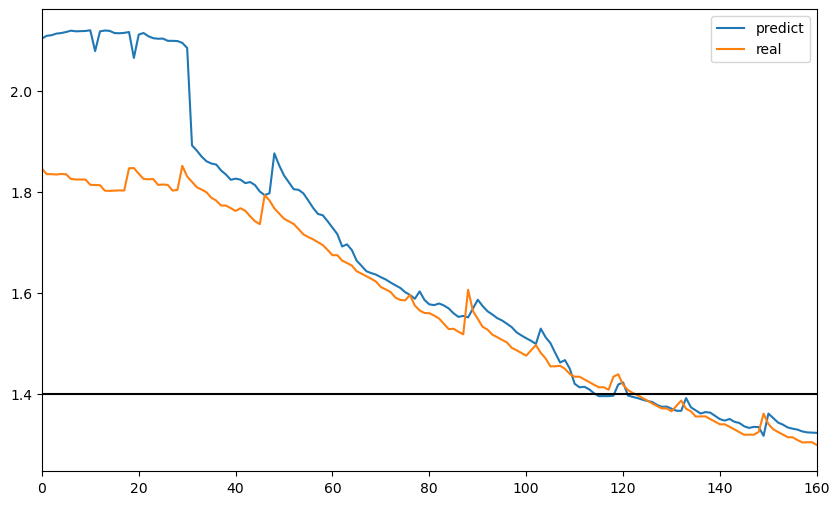

In [28]:
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 6]
plt.xlim([0, 160])

plt.plot(predicts_df.index, predicts_df.iloc[:,0], label='predict')
plt.plot(range(len(y_df.index)), y_df.iloc[:,0], label='real')
plt.plot(range(len(y_df.index)), [1.4 for i in range(len(y_df.index))], color='black')

plt.legend()
plt.show()

predicts_df.to_csv("../PREDICT/CNN_30K_15K.csv", index = False)